In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 4 GPUs.  Setting memory growth = True.


In [3]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [4]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [5]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [6]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [7]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [8]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [9]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [10]:
# # Review unperturbed elements
# elts_ast

In [11]:
# Inputs to perturb elements: small
sigma_a = 0.01
sigma_e = 0.0025
sigma_inc_deg = 0.05
sigma_f_deg = 0.25
sigma_Omega_deg = 0.25
sigma_omega_deg = 0.25
mask_pert = None
random_seed = 42

In [12]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [13]:
# Choose which elements to search on
elts = elts_pert

In [14]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [15]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [16]:
# Review nearest asteroid to these candidate elements
# elts_near

In [17]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [18]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [19]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [20]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,16.755600,-0.063945,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.025900,5342.395278,0.999665,0.550588,False
1,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,16.035999,-0.071871,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.033026,6812.476092,0.999455,0.895261,False
2,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,17.196199,0.005674,...,0.003801,0.012795,-0.977103,0.212383,2.702320,0.007222,1489.642347,0.999974,0.042810,False
3,82356,733,b'ZTF18abfivlq',580301301415015008,4298,58334.301308,269.895080,-12.887404,18.069599,-0.001785,...,0.004122,-0.020236,-0.985475,0.168609,2.108963,0.023598,4867.556965,0.999722,0.457068,False
4,82357,733,b'ZTF18abfivlq',580340131415015012,4342,58334.340139,269.895074,-12.887407,15.471100,-0.001785,...,0.004122,-0.020329,-0.985464,0.168661,2.109275,0.023637,4875.610226,0.999721,0.458582,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315312,5651017,324582,b'ZTF20aaqvkiv',1150185310015015007,96634,58904.185313,43.164491,30.568791,19.821800,0.628021,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.031535,6504.889092,0.999503,0.816249,False
315313,5651103,324582,b'ZTF20aaqvkiu',1150185310015015006,96634,58904.185313,42.979527,30.566971,19.499599,0.629931,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.033577,6926.136324,0.999436,0.925381,False
315314,5651180,324582,b'ZTF20aaqvkur',1150185310315015001,96634,58904.185313,42.969119,30.230791,18.551399,0.632210,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.030243,6238.306185,0.999543,0.750722,False
315315,5651234,324582,b'ZTF20aaqvkyr',1150185754815015006,96635,58904.185752,42.384302,29.148349,18.648100,0.645100,...,-0.001586,0.620233,0.757067,0.205329,2.936165,0.034777,7173.582036,0.999395,0.992676,False


In [21]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [22]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   315317   (     4927)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     252.73
Sqrt(batch_obs):      70.19
Mean t_score   :       3.71


In [23]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [24]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [25]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [26]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.682597,0.217803,0.499641,4.705231,2.451220,-1.132557,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.631087,0.263394,0.464606,5.735210,1.769592,-1.606798,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.895464,0.047647,0.391007,6.136626,0.801253,-1.245314,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.595620,0.098526,0.261602,5.453543,2.211553,-1.355664,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.613817,0.191549,0.513090,0.233977,0.942074,-1.303158,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.241410,0.085789,0.117903,0.042534,2.901296,-3.012575,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.600280,0.141038,0.513184,0.275664,0.641888,-0.948576,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.614547,0.096713,0.199311,5.540046,3.263431,3.953275,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.316521,0.196779,0.438674,5.281107,3.200757,3.941057,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [27]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [28]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
optimizer_type = 'adam'

In [29]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, 
                ztf_elt=ztf_elt, 
                site_name=site_name, 
                thresh_deg=thresh_deg,
                optimizer_type=optimizer_type,
                learning_rate=learning_rate, 
                clipnorm=clipnorm,
                name='model')

In [30]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :    11.59  :   0.00 :  1799.79 :  7200.00
Mean     :    11.59  :   0.00 :  1799.79 :  7200.00
Median   :    10.98  :   0.00 :  1792.83 :  7200.00
GeoMean  :    11.22  :   0.00 :  1799.78 :  7200.99
Min      :     6.80  :   0.00 :  1792.82 :  7200.00
Max      :    21.53  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [31]:
raise ValueError

ValueError: 

## Automated Training with Sieve Method


********************************************************************************
Round 1: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 3200 samples
Epoch 1/4
3200/3200 [==============================] - 4s 1ms/sample - loss: -595091.4187
Epoch 2/4
3200/3200 [==============================] - 2s 515us/sample - loss: -658464.2612
Epoch 3/4
3200/3200 [==============================] - 2s 471us/sample - loss: -733560.6663
Epoch 4/4
3200/3200 [==============================] - 2s 494us/sample - loss: -823899.7738
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1730.37 :  1730.37 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :     17.91 :    17.91 :      nan
Mean Hits           :      0.

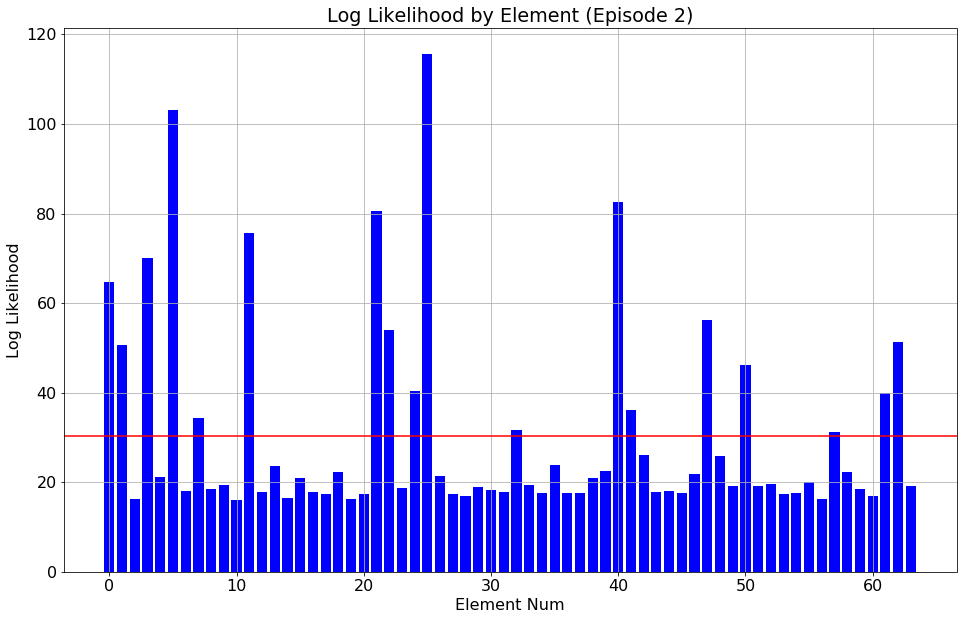

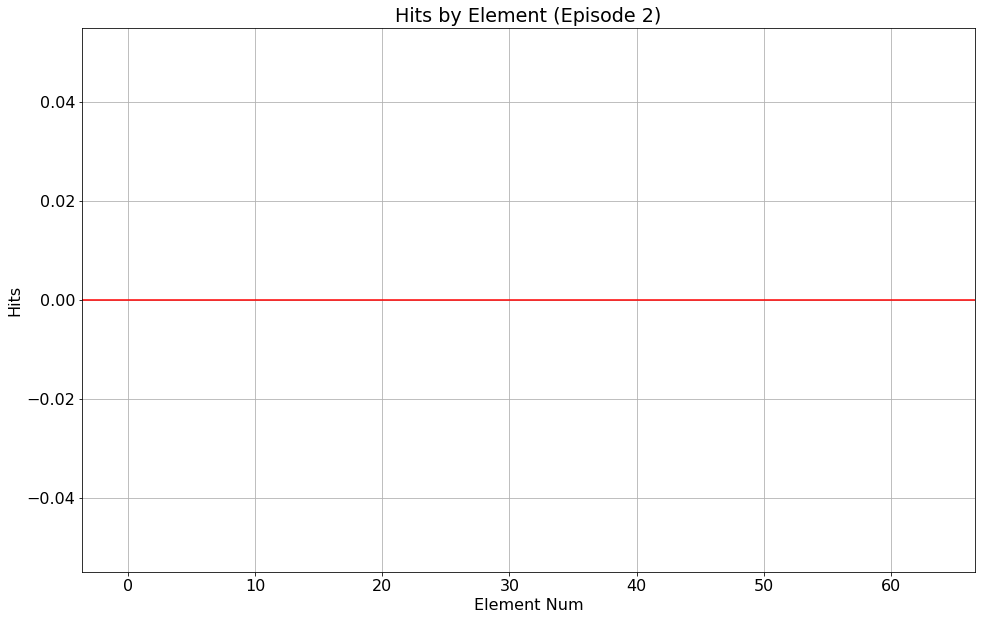


********************************************************************************
Round 2: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    400
effective_learning_rate=1.526e-05, training_time 116 sec.
Train on 3200 samples
Epoch 9/12
3200/3200 [==============================] - 5s 1ms/sample - loss: -2045429.0475
Epoch 10/12
3200/3200 [==============================] - 2s 694us/sample - loss: -2220027.1750
Epoch 11/12
3200/3200 [==============================] - 2s 612us/sample - loss: -2285435.7500
Epoch 12/12
3200/3200 [==============================] - 2s 613us/sample - loss: -2334935.4050
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1529.82 :  1529.82 :      nan arc seconds
Geom Mean Threshold :   7179.06 :  7179.06 :      nan arc seconds
Mean Log Likelihood :     47

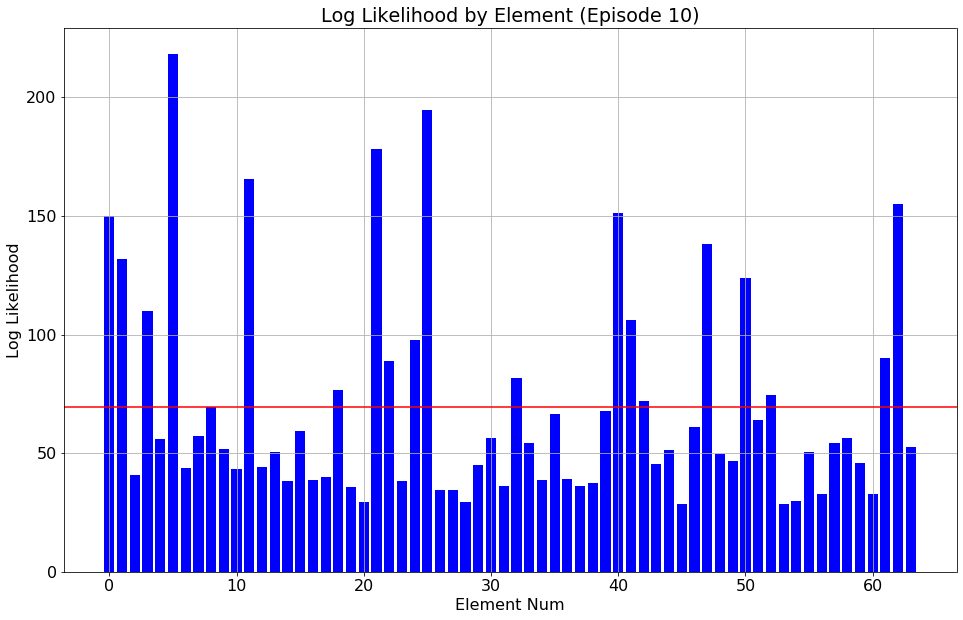

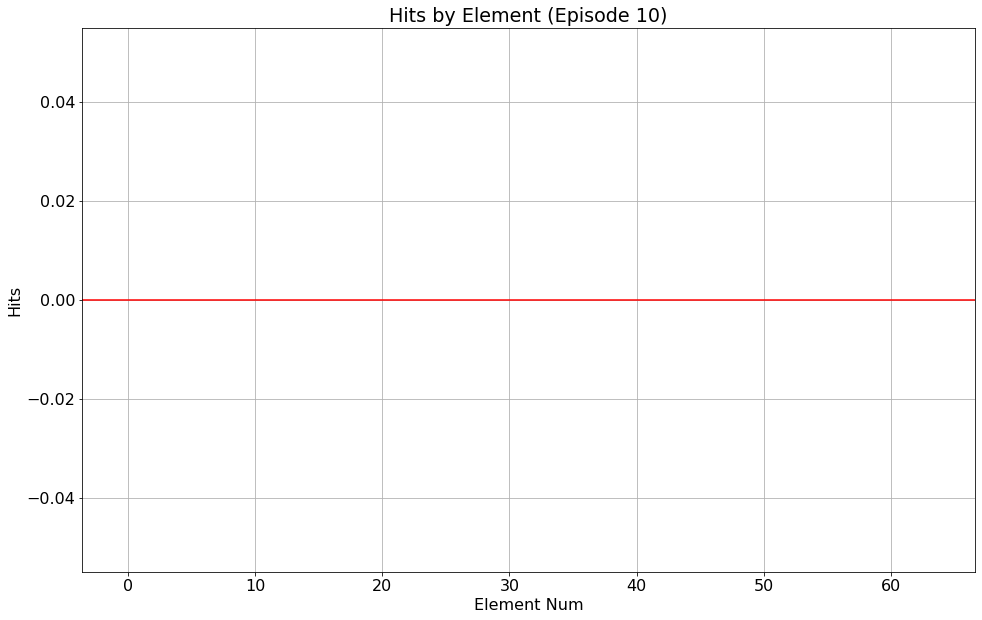


********************************************************************************
Round 3: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2000
effective_learning_rate=1.526e-05, training_time 195 sec.
Train on 3200 samples
Epoch 41/44
3200/3200 [==============================] - 3s 967us/sample - loss: -5727258.1300
Epoch 42/44
3200/3200 [==============================] - 2s 519us/sample - loss: -7165563.9400
Epoch 43/44
3200/3200 [==============================] - 2s 518us/sample - loss: -9404241.7400
Epoch 44/44
3200/3200 [==============================] - 1s 449us/sample - loss: -12977719.0000
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    836.63 :   836.63 :      nan arc seconds
Geom Mean Threshold :   4819.81 :  4819.81 :      nan arc seconds
Mean Log Likelihood :    102.72 :   102.72 :      nan
Mean Hits  

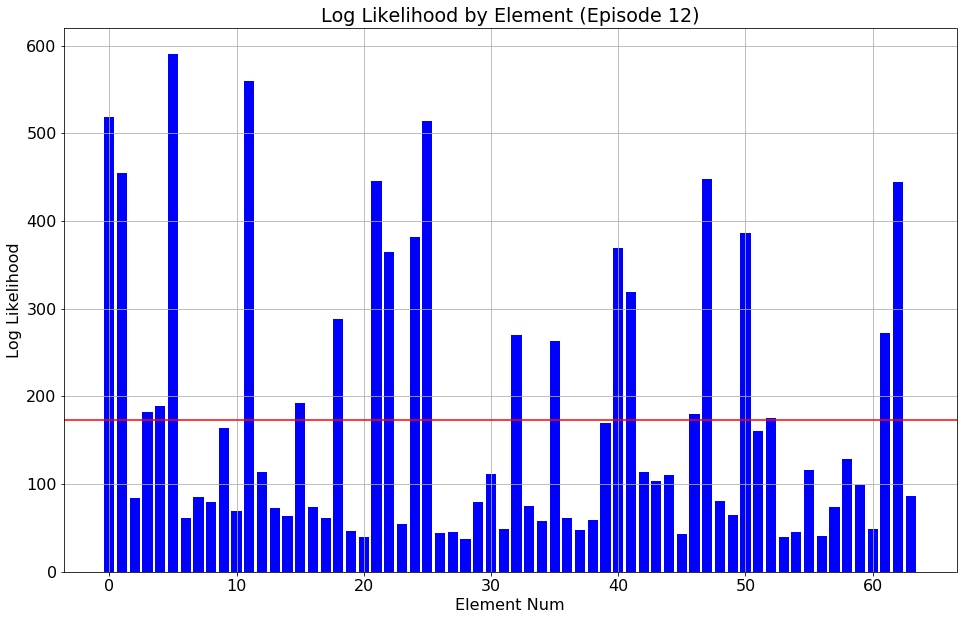

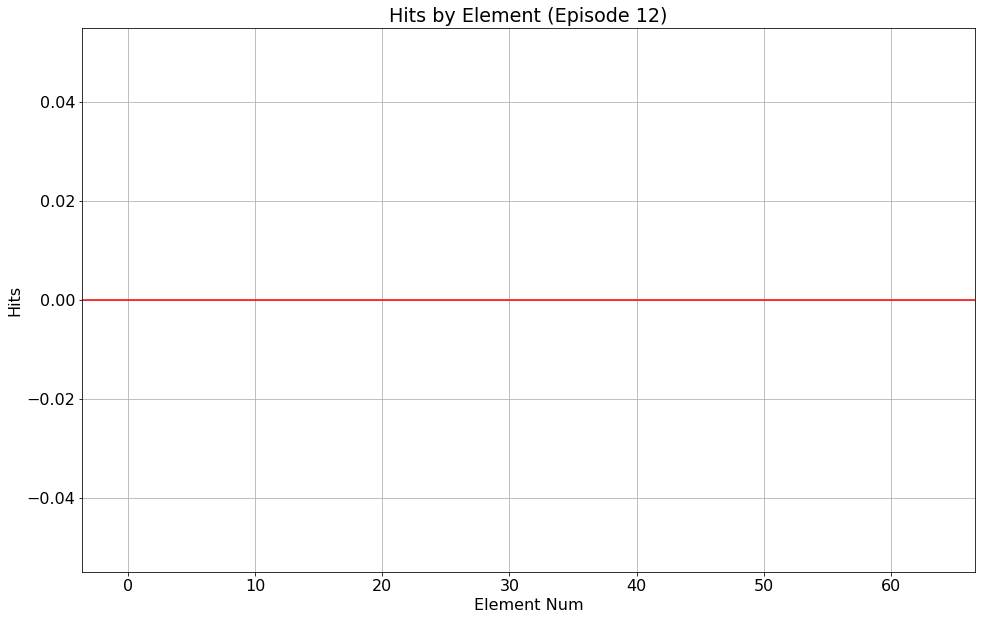


********************************************************************************
Round 4: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   2400
effective_learning_rate=1.526e-05, training_time 211 sec.
Train on 3200 samples
Epoch 49/52
3200/3200 [==============================] - 5s 1ms/sample - loss: -94438905.2800
Epoch 50/52
3200/3200 [==============================] - 2s 642us/sample - loss: -96927144.0000
Epoch 51/52
3200/3200 [==============================] - 2s 561us/sample - loss: -98668402.2400
Epoch 52/52
3200/3200 [==============================] - 2s 700us/sample - loss: -100417652.9600
Adjusted element weight down on 1 candidate elements. Mean weight = 9.92e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    551.42 :   551.42 :      nan arc seconds
Geom Mean 

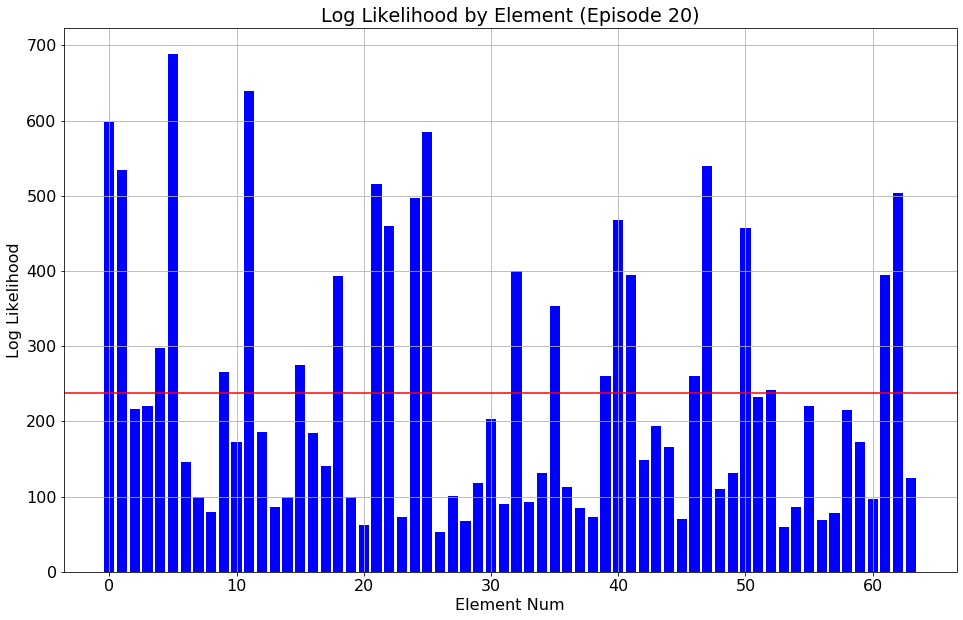

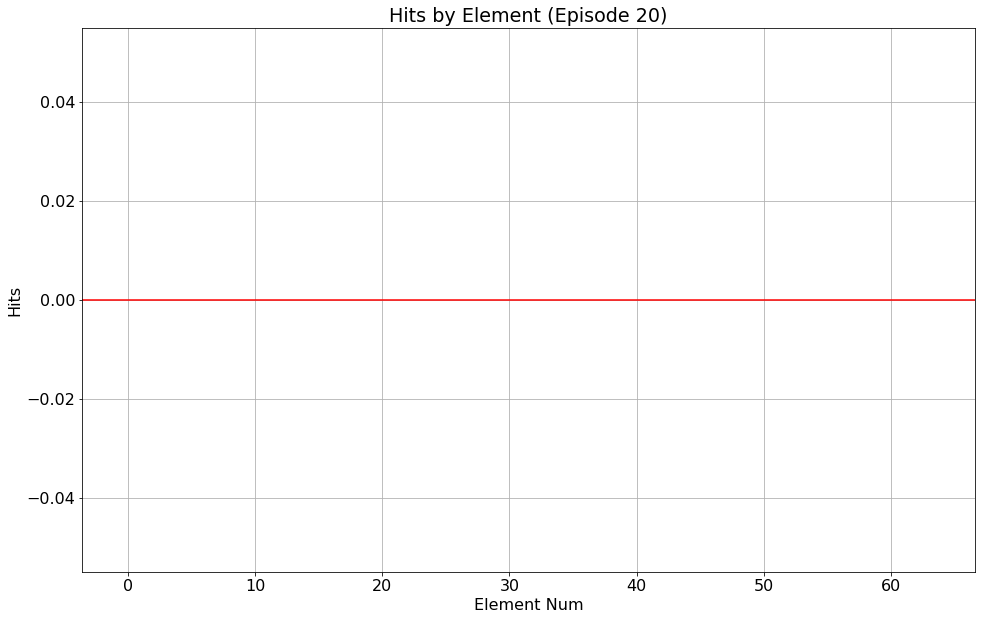


********************************************************************************
Round 5: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 20: Epoch   80, Batch   4000
effective_learning_rate=1.480e-05, training_time 292 sec.
Train on 3200 samples
Epoch 81/84
3200/3200 [==============================] - 4s 1ms/sample - loss: -179129897.6000
Epoch 82/84
3200/3200 [==============================] - 2s 517us/sample - loss: -218335994.5600
Epoch 83/84
3200/3200 [==============================] - 2s 551us/sample - loss: -270024310.4000
Epoch 84/84
3200/3200 [==============================] - 2s 497us/sample - loss: -340809300.4800
Adjusted element weight down on 2 candidate elements. Mean weight = 9.84e-01
                    \  All Elts : Bad Elts : Good Elts (3)
Geom Mean Resolution:    346.20 :   373.63 :    73.45 arc seconds
Geom Mean Threshold :   2271.68 :  2357.12 :  107

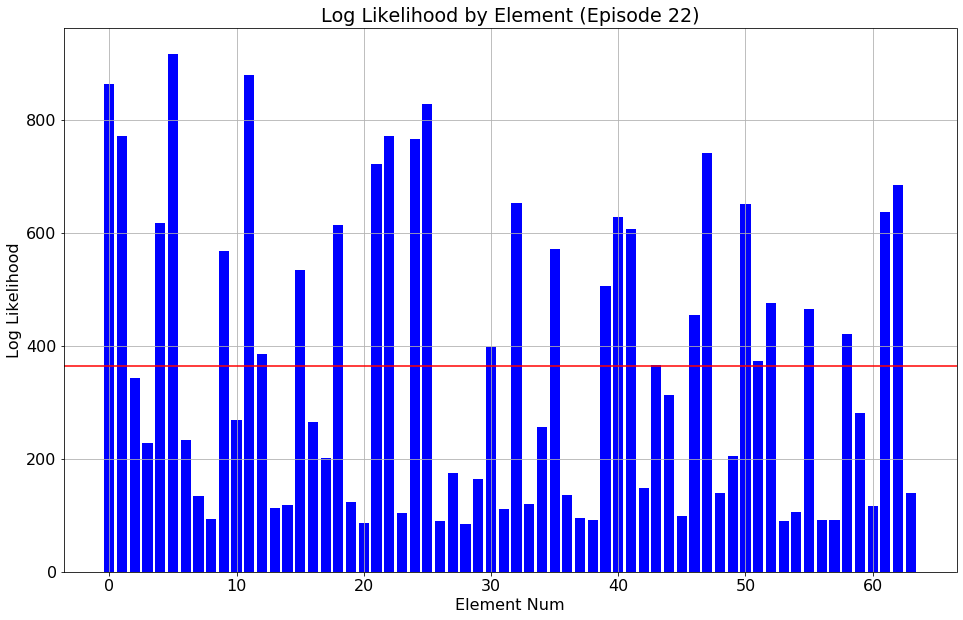

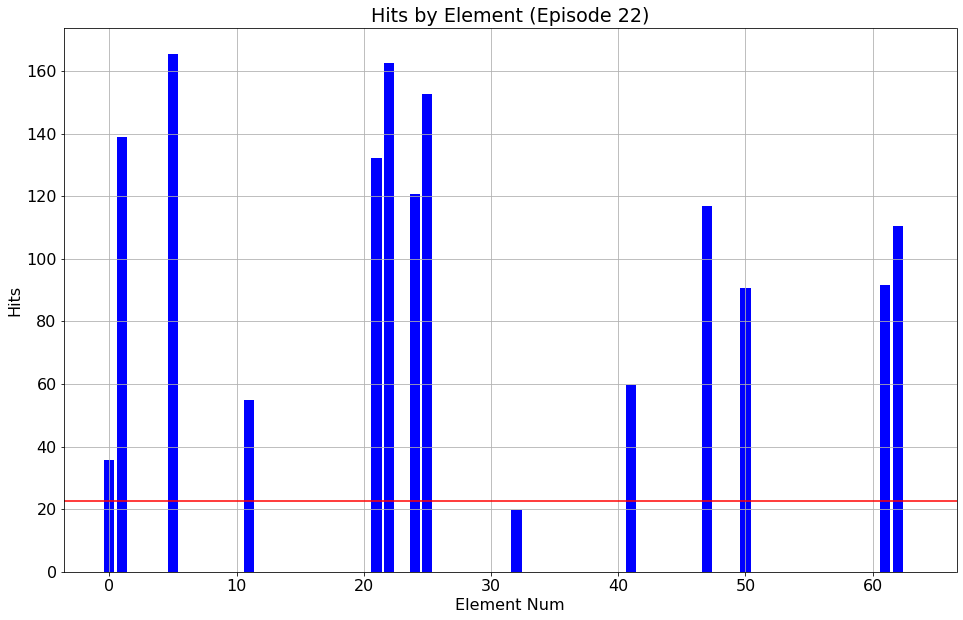


********************************************************************************
Round 6: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 22: Epoch   88, Batch   4400
effective_learning_rate=2.375e-04, training_time 311 sec.
Train on 3200 samples
Epoch 89/92
3200/3200 [==============================] - 4s 1ms/sample - loss: -1196585917.4400
Epoch 90/92
3200/3200 [==============================] - 2s 633us/sample - loss: -1260272642.5600
Epoch 91/92
3200/3200 [==============================] - 2s 660us/sample - loss: -1277974499.8400
Epoch 92/92
3200/3200 [==============================] - 2s 660us/sample - loss: -1295188241.9200
                    \  All Elts : Bad Elts : Good Elts (14)
Geom Mean Resolution:    245.13 :   390.51 :    46.47 arc seconds
Geom Mean Threshold :   1628.17 :  2113.65 :   641.10 arc seconds
Mean Log Like

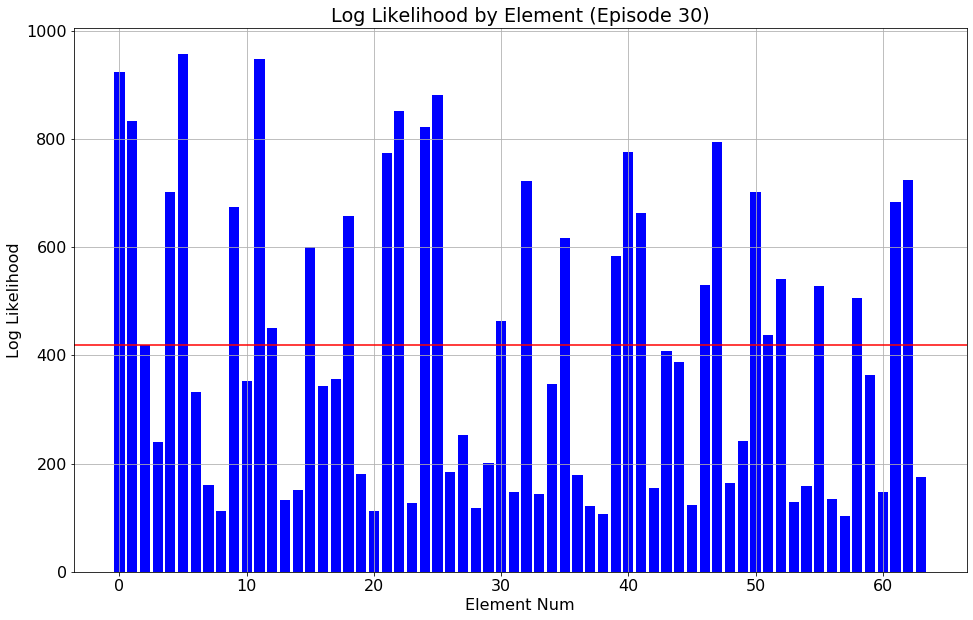

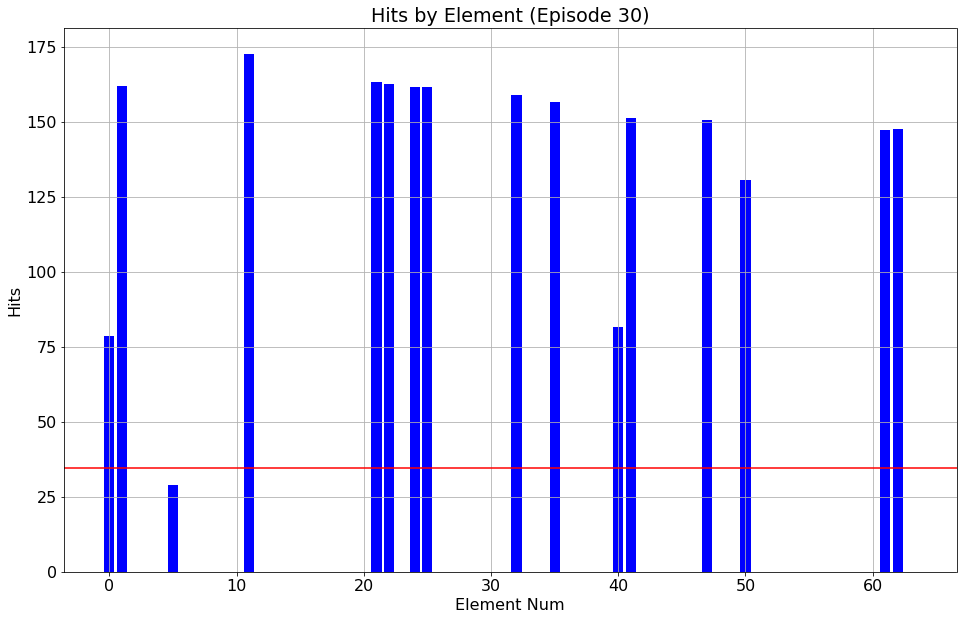


********************************************************************************
Round 7: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3000.0
********************************************************************************

Training episode 30: Epoch  120, Batch   6000
effective_learning_rate=2.441e-04, training_time 391 sec.
Train on 3200 samples
Epoch 121/124
3200/3200 [==============================] - 4s 1ms/sample - loss: -2000279283.2000
Epoch 122/124
3200/3200 [==============================] - 2s 581us/sample - loss: -2371385036.8000
Epoch 123/124
3200/3200 [==============================] - 2s 579us/sample - loss: -2847222492.1600
Epoch 124/124
3200/3200 [==============================] - 2s 569us/sample - loss: -3472990080.0000
Adjusted element weight down on 3 candidate elements. Mean weight = 9.77e-01
                    \  All Elts : Bad Elts : Good Elts (23)
Geom Mean Resolution:    175.82 :   425.56 :    36.37 arc seconds
Geom Mean Threshold :   1149.94 :  1

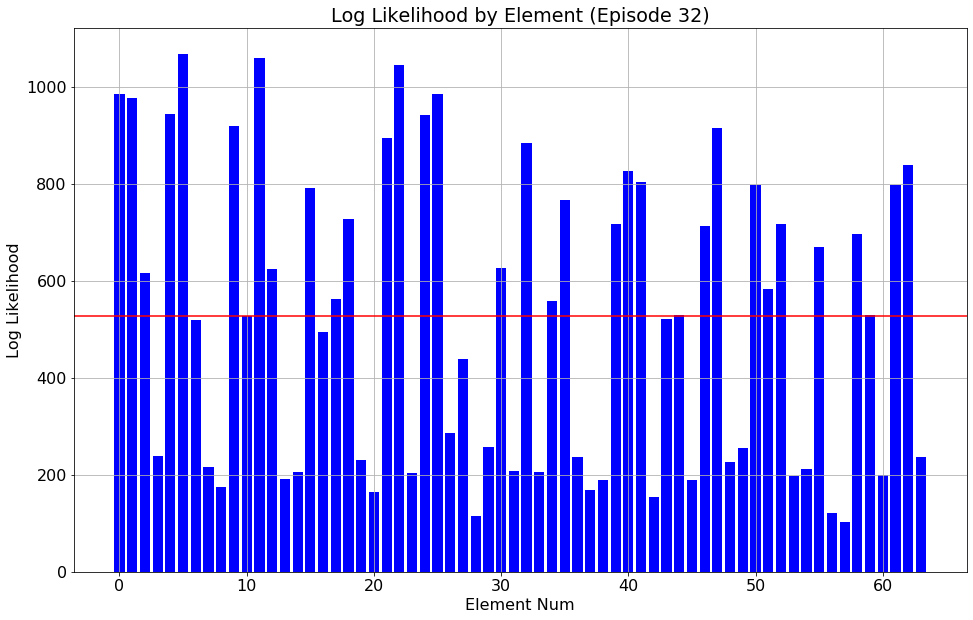

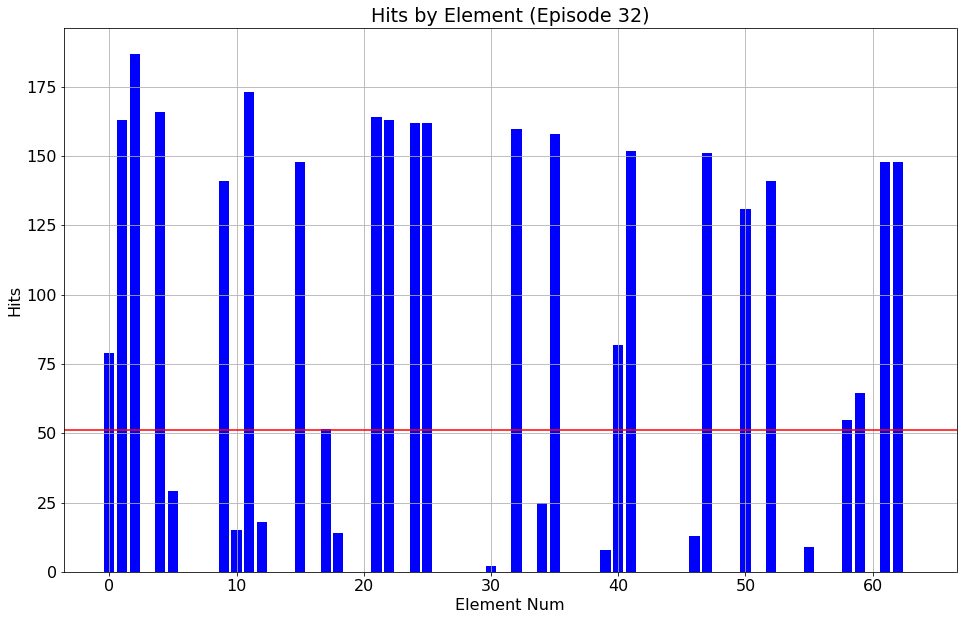


********************************************************************************
Round 8: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 32: Epoch  128, Batch   6400
effective_learning_rate=1.526e-05, training_time 410 sec.
Train on 3200 samples
Epoch 129/132
3200/3200 [==============================] - 5s 1ms/sample - loss: inf
Adjusted element weight down on 19 candidate elements. Mean weight = 8.52e-01
                    \  All Elts : Bad Elts : Good Elts (32)
Geom Mean Resolution:    133.01 :   536.92 :    32.95 arc seconds
Geom Mean Threshold :    871.07 :  1943.75 :   390.36 arc seconds
Mean Log Likelihood :    530.62 :   271.10 :   790.13
Mean Hits           :     55.83 :     0.28 :   111.37
Good Elements       :     32.00

Training episode 33: Epoch  129, Batch   6450
effective_learning_rate=1.299e-05, training_time 416 

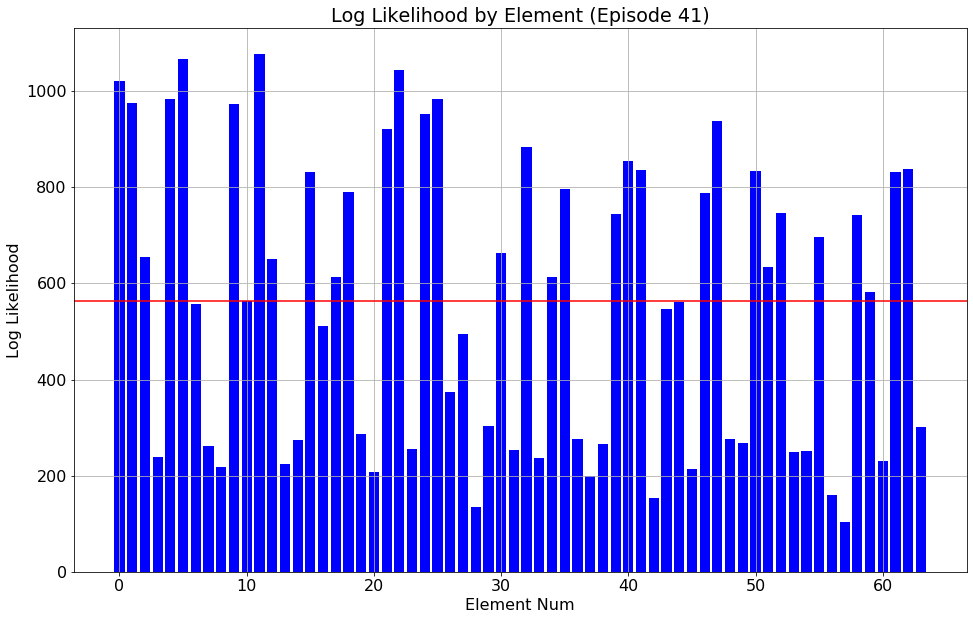

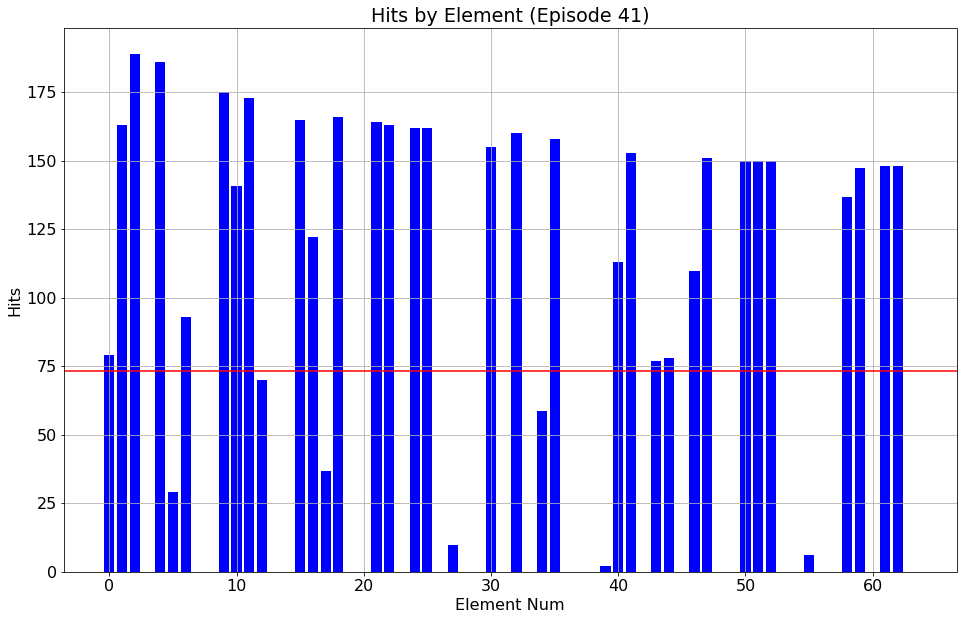


********************************************************************************
Round 9: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 41: Epoch  161, Batch   8050
effective_learning_rate=1.073e-05, training_time 499 sec.
Train on 3200 samples
Epoch 162/165
3200/3200 [==============================] - 4s 1ms/sample - loss: -12417387704.3200
Epoch 163/165
3200/3200 [==============================] - 2s 578us/sample - loss: -14416793825.2800
Epoch 164/165
3200/3200 [==============================] - 2s 588us/sample - loss: -16899516088.3200
Epoch 165/165
3200/3200 [==============================] - 2s 601us/sample - loss: -19996119654.4000
Adjusted element weight down on 11 candidate elements. Mean weight = 8.75e-01
                    \  All Elts : Bad Elts : Good Elts (36)
Geom Mean Resolution:     99.43 :   653.43 :    22.99 arc seconds
Geom Mean Threshold :    584.83

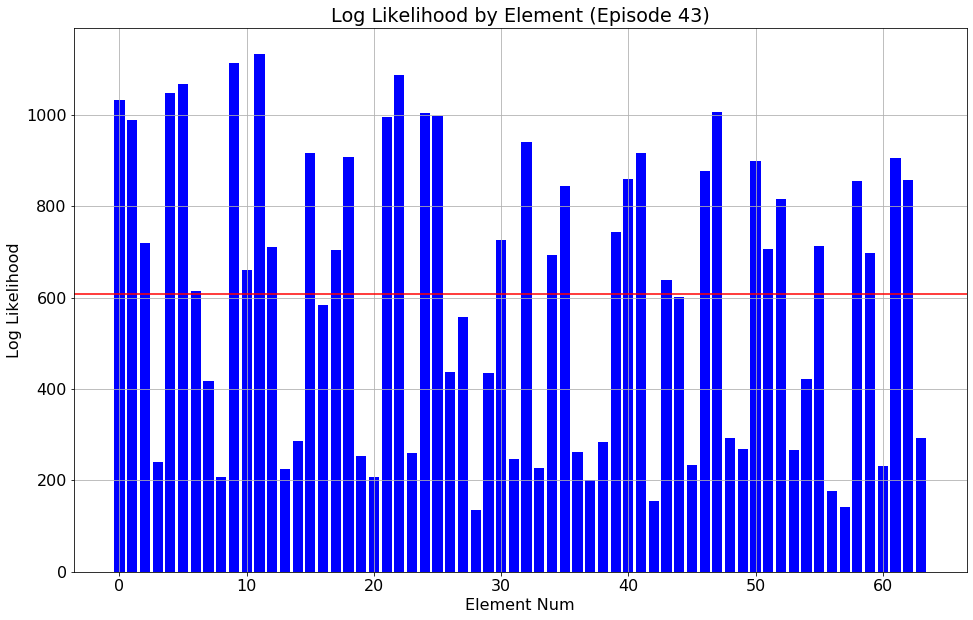

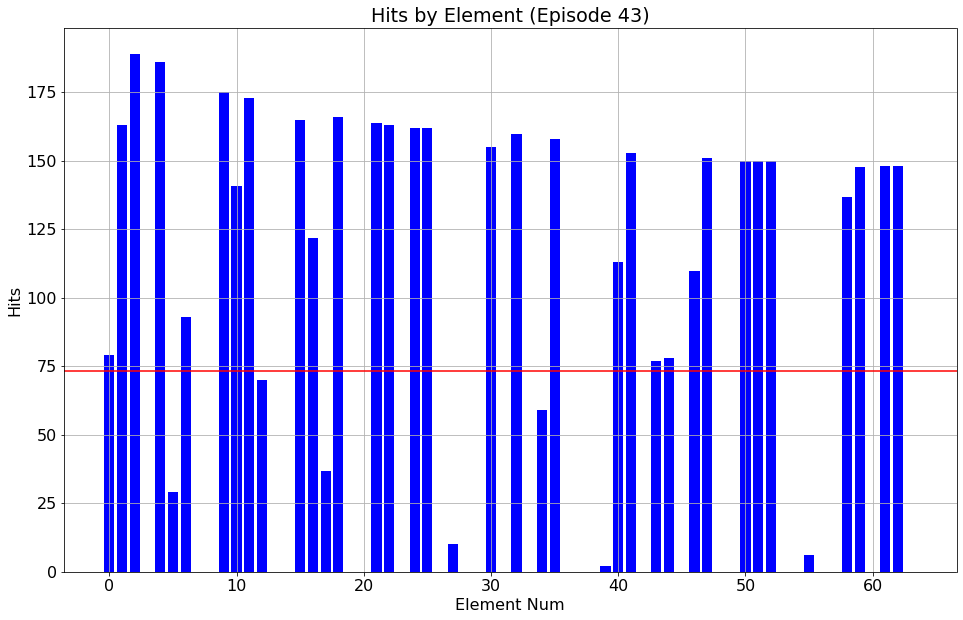


********************************************************************************
Round 10: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 43: Epoch  169, Batch   8450
effective_learning_rate=1.760e-04, training_time 520 sec.
Train on 3200 samples
Epoch 170/173
3200/3200 [==============================] - 5s 2ms/sample - loss: inf
Adjusted element weight down on 34 candidate elements. Mean weight = 5.67e-01
                    \  All Elts : Bad Elts : Good Elts (36)
Geom Mean Resolution:     78.38 :   663.66 :    14.88 arc seconds
Geom Mean Threshold :    473.94 :  1477.93 :   195.68 arc seconds
Mean Log Likelihood :    611.23 :   300.20 :   853.14
Mean Hits           :     75.16 :     0.29 :   133.40
Good Elements       :     36.00

Training episode 44: Epoch  170, Batch   8500
effective_learning_rate=8.646e-06, training_time 526

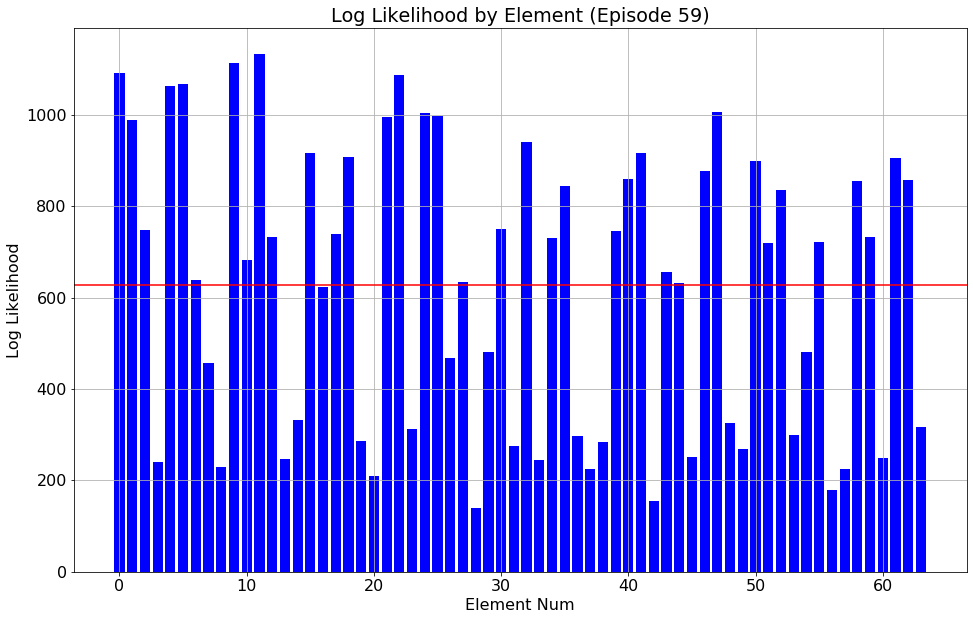

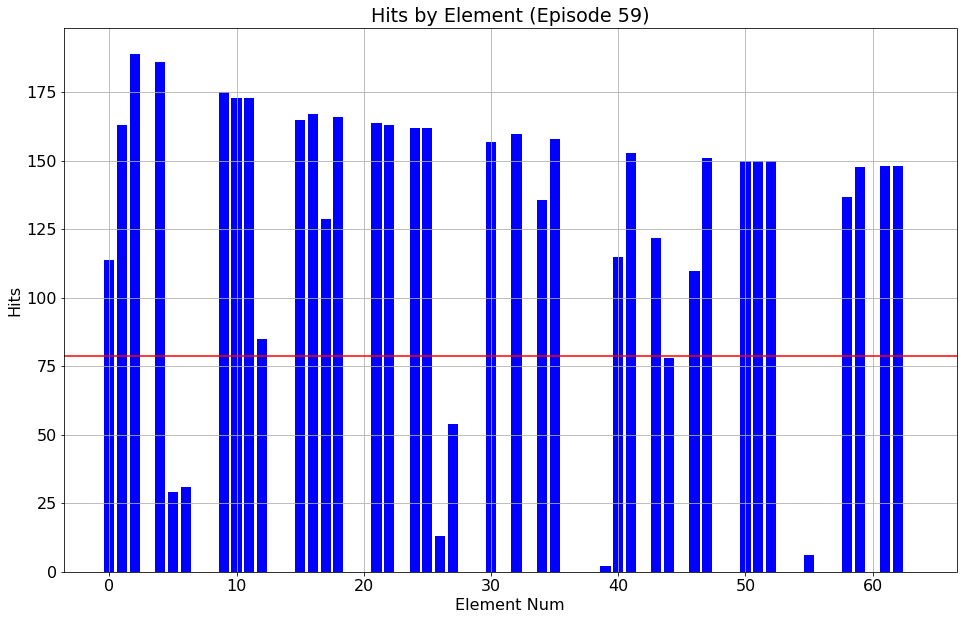


********************************************************************************
Round 11: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 1800.0
********************************************************************************

Training episode 59: Epoch  200, Batch  10000
effective_learning_rate=4.417e-06, training_time 622 sec.
Train on 3200 samples
Epoch 201/204
3200/3200 [==============================] - 4s 1ms/sample - loss: -45253984747.5200
Epoch 202/204
3200/3200 [==============================] - 2s 687us/sample - loss: -51893551104.0000
Epoch 203/204
3200/3200 [==============================] - 2s 681us/sample - loss: -59949692600.3200
Epoch 204/204
3200/3200 [==============================] - 2s 633us/sample - loss: -69882730577.9200
Adjusted element weight down on 31 candidate elements. Mean weight = 5.94e-01
                    \  All Elts : Bad Elts : Good Elts (37)
Geom Mean Resolution:     59.16 :   573.25 :    11.28 arc seconds
Geom Mean Threshold :    373.6

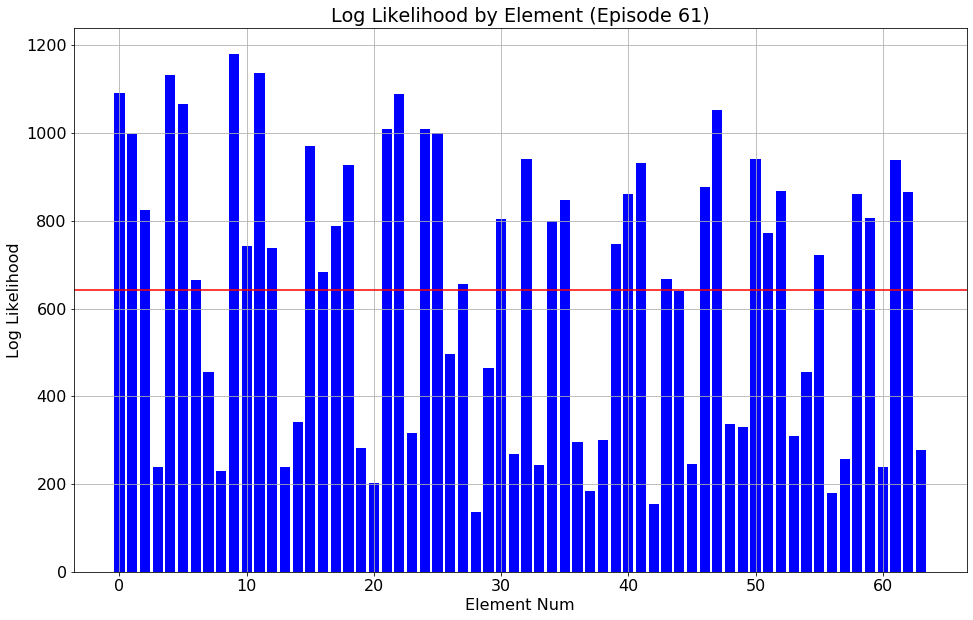

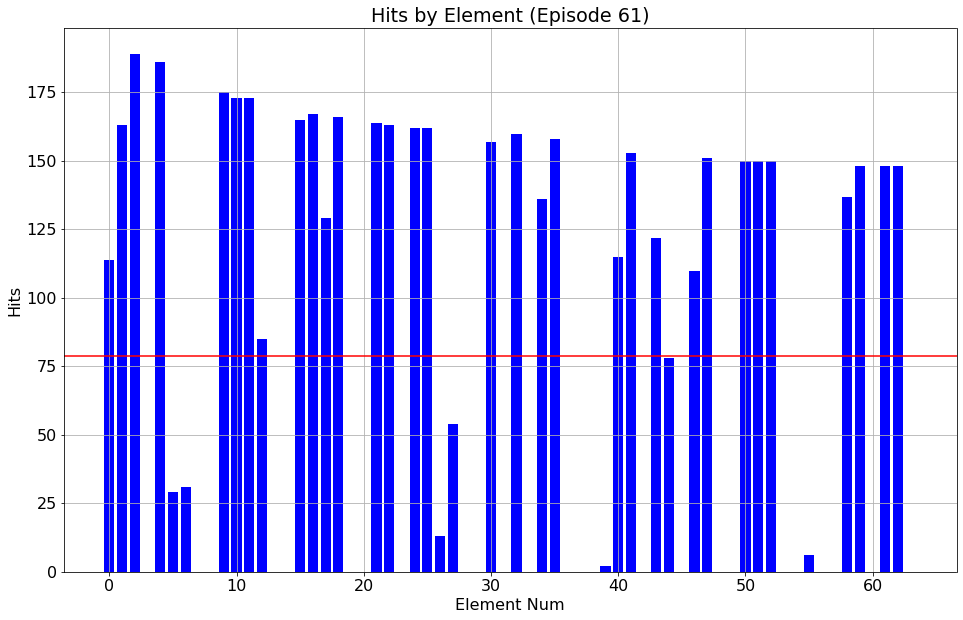


********************************************************************************
Round 12: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 61: Epoch  208, Batch  10400
effective_learning_rate=1.087e-04, training_time 645 sec.
Train on 3200 samples
Epoch 209/212
3200/3200 [==============================] - 5s 2ms/sample - loss: inf
Adjusted element weight down on 45 candidate elements. Mean weight = 2.27e-01
                    \  All Elts : Bad Elts : Good Elts (36)
Geom Mean Resolution:     52.26 :   541.06 :     8.49 arc seconds
Geom Mean Threshold :    332.38 :  1156.39 :   126.04 arc seconds
Mean Log Likelihood :    644.47 :   323.58 :   894.06
Mean Hits           :     78.81 :     0.29 :   139.88
Good Elements       :     36.00

Training episode 62: Epoch  209, Batch  10450
effective_learning_rate=3.469e-06, training_time 651

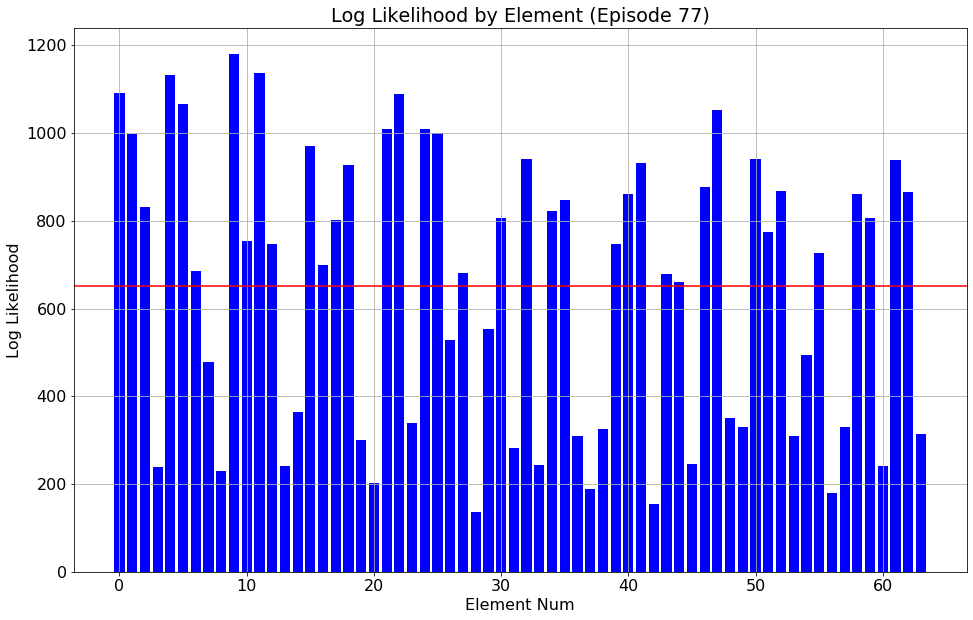

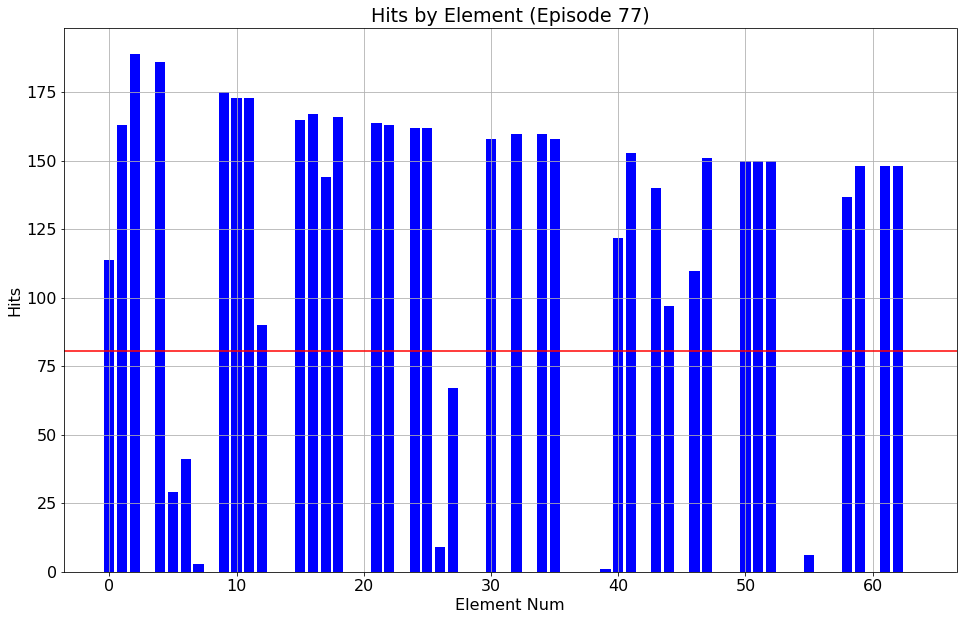


Training episode 77: Epoch  238, Batch  11900
effective_learning_rate=2.441e-04, training_time 749 sec.
Train on 3200 samples
Epoch 239/242
3200/3200 [==============================] - 4s 1ms/sample - loss: -119712707706.8800
Epoch 240/242
3200/3200 [==============================] - 2s 703us/sample - loss: -131728719708.1600
Epoch 241/242
3200/3200 [==============================] - 2s 733us/sample - loss: -145467346124.8000
Epoch 242/242
3200/3200 [==============================] - 2s 774us/sample - loss: -161257319956.4800
Adjusted element weight down on 39 candidate elements. Mean weight = 6.95e-01
                    \  All Elts : Bad Elts : Good Elts (36)
Geom Mean Resolution:     27.32 :   160.53 :     6.89 arc seconds
Geom Mean Threshold :    188.49 :   386.18 :   107.90 arc seconds
Mean Log Likelihood :    567.45 :   131.12 :   906.81
Mean Hits           :     80.50 :     0.68 :   142.58
Good Elements       :     36.00

Training episode 78: Epoch  242, Batch  12100
effective_

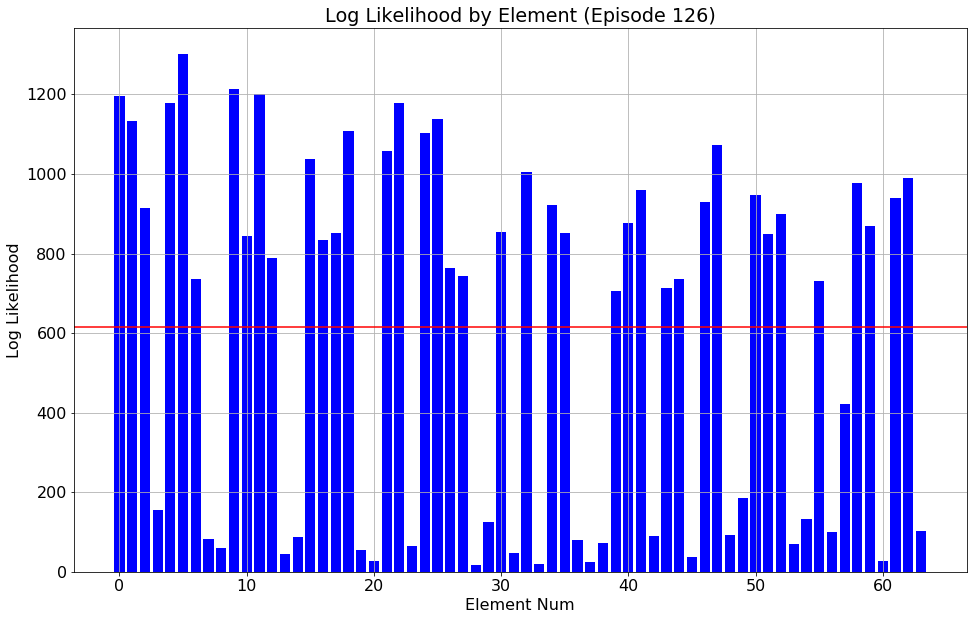

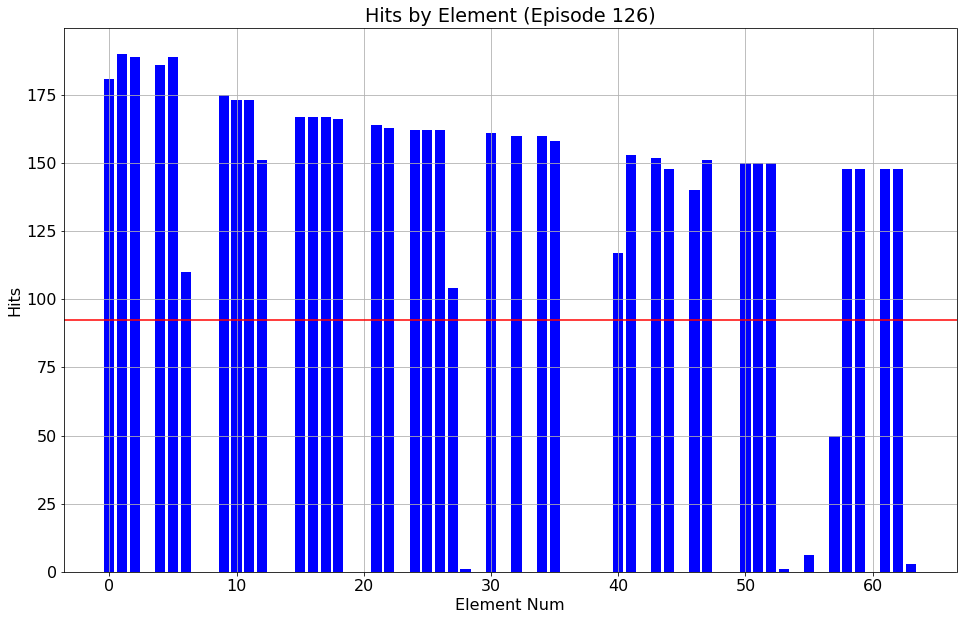

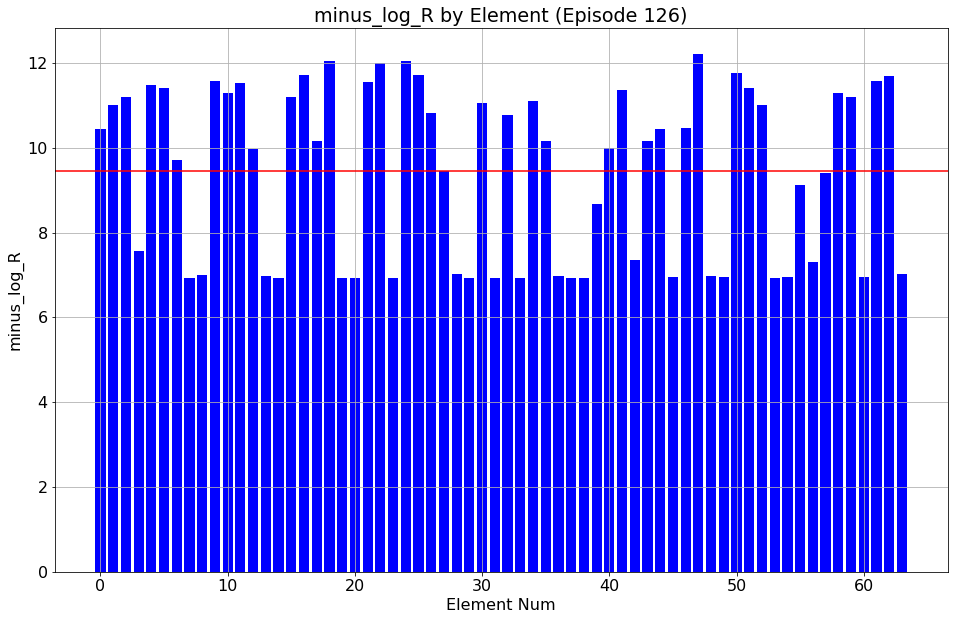

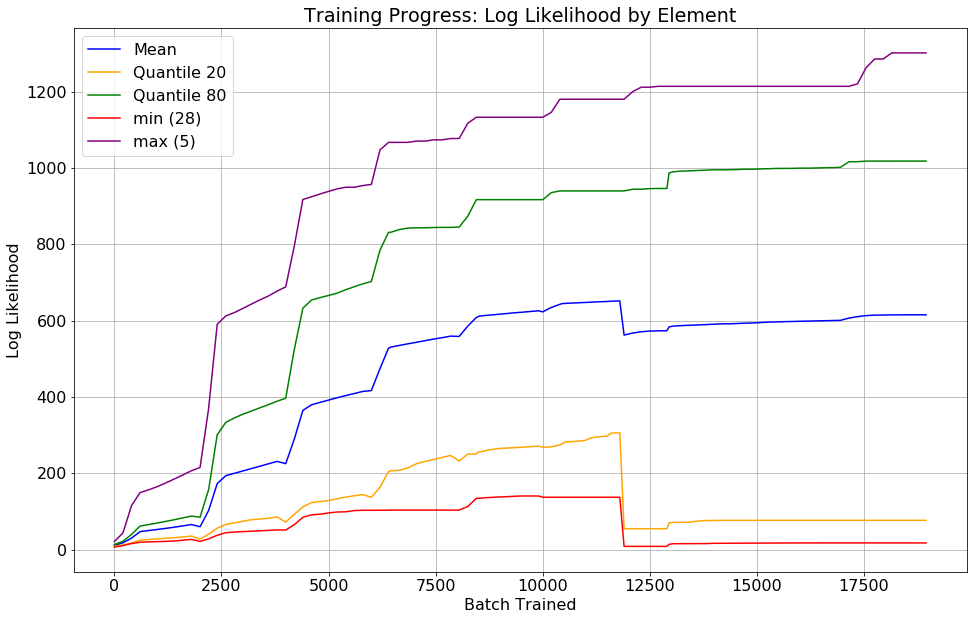

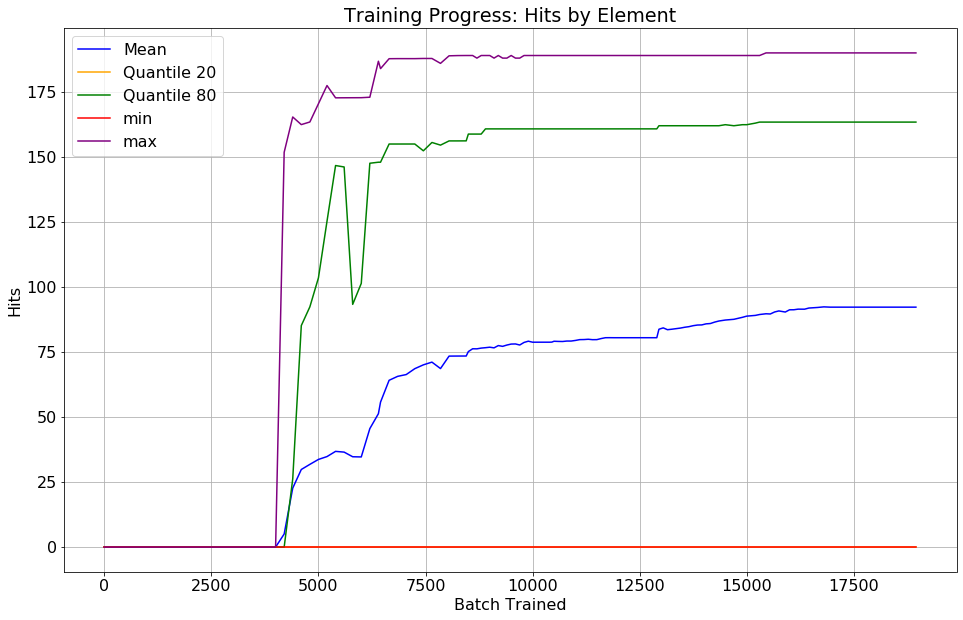

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Sub: Dst tensor is not initialized. [Op:Sub] name: sub/

In [32]:
model.sieve()

In [ ]:
model.load()

In [33]:
model.report()


Good elements (hits >= 10):  38.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   950.95  : 155.08 :     4.48 :    68.68
Mean Bad :   124.55  :   0.42 :   175.43 :   376.76
Mean     :   615.22  :  92.25 :    73.93 :   193.84
Median   :   775.46  : 148.00 :     8.02 :   100.65
GeoMean  :   335.50  :  20.34 :    18.33 :   129.13
Min      :    17.68  :   0.00 :     1.03 :    18.85
Max      :  1301.35  : 190.00 :   200.00 :   399.11
Trained for 18950 batches over 379 epochs and 126 episodes (elapsed time 1218 seconds).


In [ ]:
R_s = model.get_mixture_params()[1]

In [ ]:
R_sec = dist2sec(R_s)
thresh_sec_max = np.minimum(2*R_sec, 50)
R_sec

In [ ]:
self = model
self.set_thresh_sec_max(400.0)
self.set_R_sec_max(200.0)

In [ ]:
self.thaw_mixture_parameters()
self.freeze_candidate_elements()
self.search_adaptive(
            max_batches=self.current_batch + 2000,
            batches_per_epoch=50,
            epochs_per_episode=5,
            learning_rate=2**-12,
            min_learning_rate=2**-24,
            reset_active_weight=True)

In [ ]:
self.thaw_candidate_elements()
self.search_adaptive(
            max_batches=self.current_batch + 4000,
            batches_per_epoch=50,
            epochs_per_episode=5,
            learning_rate=2**-18,
            min_learning_rate=2**-26,
            reset_active_weight=True)

In [ ]:
self.thaw_mixture_parameters()
self.freeze_candidate_elements()
self.search_adaptive(
            max_batches=self.current_batch + 1000,
            batches_per_epoch=50,
            epochs_per_episode=4,
            learning_rate=2**-12,
            min_learning_rate=2**-24,
            reset_active_weight=True)

In [ ]:
model.save_state()

In [ ]:
# model.load()

In [ ]:
model.report()

In [ ]:
model.plot_hist('hits')

In [ ]:
model.plot_hist('log_like')

## Distance vs. Nearest Asteroid for Fitted Elements

In [ ]:
_ = model.nearest_ast()

In [ ]:
model.report()

In [ ]:
# model.save_state()

In [ ]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.mean(model.elts_near_ast.nearest_ast_q_norm[is_converged])

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

In [ ]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

In [ ]:
# # Review fitted elements including nearest asteroid
# model.elts_fit

In [ ]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

In [ ]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)